# PID Controller Simulation

## Leaning Objectives

After completing this exercise, the student will be able to:
- Create a 1 dimentional free body diagram (`Exercise 1`)
- Create a simple model for a PID controller (`Exercise 2`)
- Numerically integrate and differentiate a signal (`Exercise 2`)
- Understanding the effects of an integration term and a derivative term on the system response (`Exercise 2`)
- (Bonus) Explore the effects of a more complex system on the PID controller response (`Exercise 3`)

## Introduction
Small drones are now a part of everything from warehouse automation to areal photography. And keeping them stable in the air is crucial to their success. Suppose we want to keep at exactly 10 meters above the grpund. This seems easy - just apply enough thrust to counteract gravity, right?

But how do we know how much thrust to apply? And what if the environment isn't still? A gust of wind could push the drone up or down, and we need to adjust the thrust accordingly. How do we do that smoothly, and without the drone oscillating up and down?

This is a problem in <a href="https://en.wikipedia.org/wiki/Control_theory">Control theory</a>, and it is solved using something callled a PID controller. PID stands for Proportional, Integral, and Derivative, and it is a type of feedback controller that adjusts the output based on the error between the desired setpoint and the actual value. It continuously adjusts the drone's thrust based on how far it is from the desired altitude, how long it has been at that altitude, and how fast the drone is moving.

In this project, we will simulate a 1-dimensional PID controller that attempts to keep a drone stable at a desired hight. We will explore how different terms in the PID controller affects the response, and see how a seemingly simple feedback loop can yield powerful control behavior.

# 1. Free Body Diagram
Before we can simulate the PID controller, we need to understand the forces acting on the drone. To do this we will create a free body diagram of the drone, to help visualize the acting forces.

Create a sketch of the system and draw a free body diagram of a hovering drone. The drone should be hovering at an arbitrary height $h$. 
Draw the acting forces into the sketch to obtain a free body diagram. We are working in 1 dimension, so we can ignore the horizontal forces. We can only control the force (acceleration) of the drone, via a "gas pedal", and we are working against gravity.

<span style=color:red>Should i include a hint on the free body diagram?</span> 

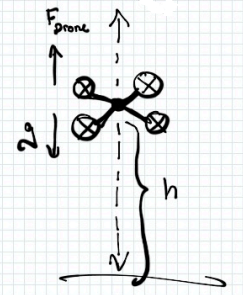
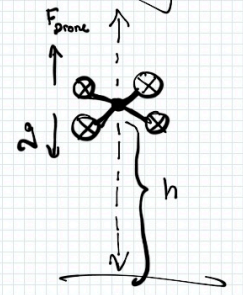

## 2. Create a simulation (multi-part)


### 2a) P controller
The term "P" stands for Proportional, and it refers to a controler that adjusts its output in proportion to the current error between the desired setpoint and the actual measurement value. In our case, the output of the controller is the thrust applied to the drone, which we represent as a function of time $u(t)$. 
$$u(t) = K_P e(t)$$

where $K_p$ is the proportional gain, $e(t)$ is the error at time $t$, and $u(t)$ is the control output (thrust).

The larger the error, the larger the output of the controller. In this first section, we want to explore the effects of a proportional controller alone on the drone's altitude.


In [1]:
import numpy as np 
import matplotlib.pyplot as plt

Find an expression for the net acceleration of the drone, $a(t)$, in terms of the thrust $u(t)$ and the gravitational force $mg$. 
Do this by first finding the net force $F_{\text{net}}=ma_{\text{net}}$, which you should be able do derive from the free body diagram you created in the previous section.

Fill in the following functions `calculate_error(setpoint, measurement)`, `proportional_term(K_p, error)` and `acceleration(u, m, g)` 

In [ ]:
def calculate_error(setpoint:float, measurement:float) -> float:
    """
    Calculate the error between the setpoint and the measurement.

    Parameters
    ----------
    setpoint: float
        Desired value.
    measurement: float
        Current system state.

    Returns
    -------
    error: float 
        The difference between setpoint and measurement.
    """
    return setpoint - measurement

def proportional_term(k_p:float, error:float) -> float:
    """
    Proportional term for a PID controller.

    Parameters
    ----------
    k_p: float
        Proportional gain.
    error: float
        The error value.

    Returns
    -------
    P: float 
        Control force based on proportional error.
    """
    return k_p * error


def acceleration(u:float, m:float, g:float) -> float:
    """
    Calculate the net vertical acceleration of a mass under control and gravity.

    Parameters
    ----------
    u: float
        Control input (force from thrusters).
    m: float
        Mass of the drone.
    g: float
        Gravitational acceleration.

    Returns
    -------
    a: float 
        Net acceleration 
    """
    return (u - m * g) / m

In the following code section, you will have to implement the Euler Cromer method to numerically integrate the velocity and position of the drone. The Euler Cromer method is a numerical method for solving ordinary differential equations. It is commonly used for simulating physical systems when we know the acceleration of the system. The method is an extension of the Euler method, but is a way more stable and reliable method. 
The Euler Cromer method in this system will look like this:

\begin{align*}
    v(t + \Delta t) &= v(t) + a(t) \Delta t\\
    r(t + \Delta t) &= r(t) + v(t + \Delta t) \Delta t
\end{align*}
where $v(t)$ is the velocity at time $t$, $r(t)$ is the position at time $t$, and $\Delta t$ is the time step.

 

In [30]:
## initialize the system
m = 1.0  # mass
setpoint = 10.0 # desired position
start_position = 0.0 # initial position
start_velocity = 0.0 # initial velocity
g = 9.81  # gravitational acceleration
K_p = 5.0  # proportional gain


n = 500
T = np.linspace(0, 20, n)  # time vector
dt = T[1] - T[0]  # time step

position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity


# Euler cromer method for numerical integration
for i in range(1, n):
    # Calculate the control input using the proportional term
    error = calculate_error(setpoint, position[i-1])
    u = proportional_term(K_p, error)

    # Calculate the acceleration
    a = acceleration(u, m, g)

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

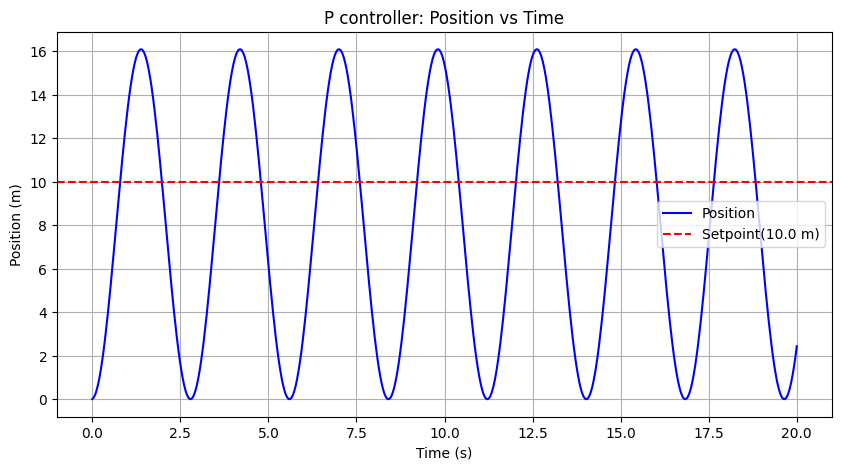

In [31]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label=f'Setpoint({setpoint} m)')
plt.title('P controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()    

Your results might look pretty bad at first, but that is expected. The P controller is not very good at keeping the drone stable. Therefore, the next step is to introduce the derivative term to the controller.

### 2b) PD controller
We have just witnessed the limitations of a P controller. It only reacts to the current error, meaning the difference between the setpoint and the measurement position, without considering how the error is changing over time. This often leads to overshooting and oscillations in the system.

To improce the controller, we will introduce a derivative term, D, which responds to the rate of change of the error. This allows the controller to anticipate where the system is heading, not just where it is not. In other words, the derivative term acts as an anticipatory control, pushing back harder when the error is changing rapidly and backing off when things are stabilizing. It effectively adds damping, which helps to smooth out the response and prevent overshooting.

Mathematically, the controller signal is now proportinal to both the error and its derivative:
$$u(t) = K_p e(t) + K_D \frac{∂ e(t)}{∂ t}$$

The next thing we need to do is to implement the derivative of the error into the simulation. A simple way of calculating the derivative is to use the difference between the current and previous error:
$$\frac{∂ e(t)}{∂ t} = \frac{e(t) - e(t-1)}{Δt}$$

Fill in the function `derivative_term(K_D, error, previous_error, dt)` below and do another Euler Cromer simulation with the PD controller. Plot the result and see how the result changes compared to the P controller. 

In [ ]:
def derivative_term(K_d:float, current_error:float, previous_error:float, dt:float)  -> float:
    """
    Derivative term for a PID controller.

    Parameters
    ----------
    K_d: float
        Derivative gain.
    current_error: float
        Current error.
    previous_error: float
        Previous error.
    dt: float
        Time step.

    Returns
    ----------
    D: float
        Control force based on derivative of error.
    """
    
    derivative = (current_error - previous_error) / dt
    return K_d * derivative

In [25]:
K_p = 2.0  # proportional gain
K_d = 5.0  # derivative gain

position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity

previous_error = calculate_error(setpoint, position[0])  # initialize previous error

for i in range(1, n):
    error = calculate_error(setpoint, position[i-1])  # calculate error

    # Calculate the control input using the proportional term
    u = proportional_term(K_p, error)

    # Calculate the derivative term
    derivative = derivative_term(K_d, error, previous_error, dt)

    u += derivative  # add derivative term to control input

    # Calculate the acceleration
    a = acceleration(u, m, g)

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

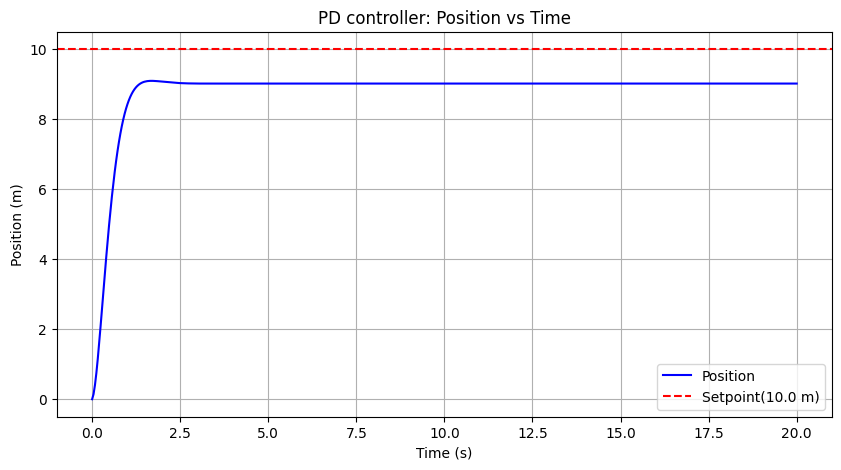

In [7]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label=f'Setpoint({setpoint} m)')
plt.title('PD controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()    

Hopefully, you have now seen an improvement in the stability of the drone. The PD controller is much better at keeping the drone stable, than when we only had the P controller. But we can still see that we are not quite there yet. Again, do not worry, we will improve the controller once again, by adding the integral term.

### 2C) PID controller
We have now seen the effects of the P and D terms in the controller. While the derivative term helps by anticipating the changes in error and daming the system response, the PD controller is still not perfect. Particularly when it comes to eliminating steady-state errors, where the drone hovers at a height that is not exactly the desired setpoint.

To adress this problem, we will introduce the integral term, I. The integral term accumulates the error over time, effectively "remembering"  the past errors. If there is any persistent difference between the setpoint and the measurement, the integral term will continue to grow, pushing the controller to adjust the output until the error is eliminated. This cumulative effect is what allows the controller to eliminate residual or static errors that the proportinal term alone cannot handle.

As the error decreases, the contribution of the from the proportinal term naturally weakens, but the integral term, having built up over time, continues to drive the output until the error is zero. Once the error reaches zero, the integral term stops growing, stabilizing the system.

Together, the three terms combine into a PID controller, which is defined as follows:

$$u(t) = K_P e(t) + K_I \int_0^t e(t) dt + K_D \frac{∂ e(t)}{∂ t} $$

Implement the integral of the error into the simulation by using a simple numerical integration method, such as a Riemann sum:
$$\int_0^t e(t) dt \approx \sum_{i=0}^{n} e(t_i) \Delta t$$


In [ ]:
def integration_term(K_I:float, accumulated_error:float, dt:float) -> float:
    """
    Integral term for a PID controller.

    Parameters
    ----------
    K_I: float
        Integral gain.
    accumulated_error: float
        Accumulated error over time.
    dt: float
        Time step.

    Returns
    ----------
    I:float 
        Control force based on integral of error.
    """
    return K_I * accumulated_error * dt

In [9]:
K_p = 10.0  # proportional gain
K_d = 5.0   # derivative gain
K_i = 5.0  # integral gain

position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity

previous_error = calculate_error(setpoint, position[0])  # initialize previous error
accumulated_error = previous_error

for i in range(1, n):
    # Calculate the error
    error = calculate_error(setpoint, position[i-1])
    # Update accumulated error for integral term
    accumulated_error += error

    # Calculate the control input using the proportional term
    u = proportional_term(K_p, error)

    # Calculate the derivative term
    derivative = derivative_term(K_d, error, previous_error, dt)

    # Calculate the integral term
    integral = integration_term(K_i, accumulated_error, dt)

    u = u + derivative + integral  # add derivative and integral terms to control input

    # Calculate the acceleration
    a = acceleration(u, m, g)

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

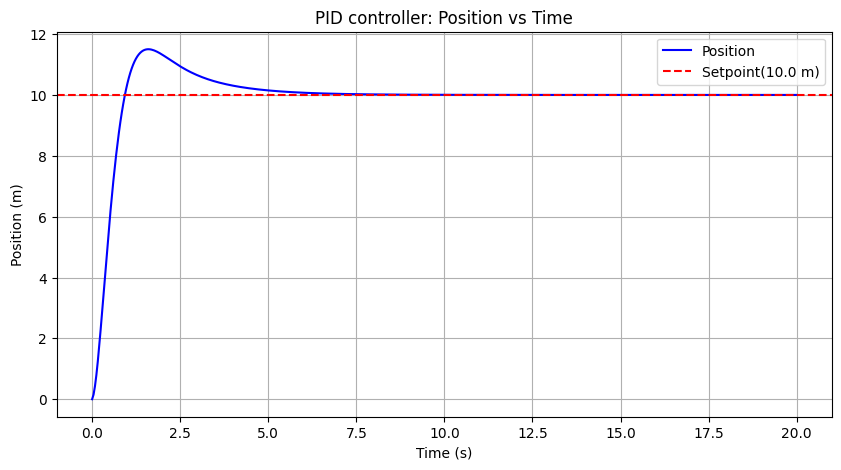

In [10]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label=f'Setpoint({setpoint} m)')
plt.title('PID controller: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()

Hopefully, you have now seen a significant improvement in the stability of the drone. You should now have a PID controller that is able to keep the drone stable at the desired setpoint. 
Now, try to play around with the different gains $K_P$, $K_I$ and $K_D$ and see how they affect the response of the system. You can also try to change the setpoint and see how the controller reacts to changes in the desired altitude.

## 3. Add random effects
In the real world, there are often random effects that can affect the stability of the drone. For example, wind gusts can push the drone up or down, and we need to adjust the thrust accordingly. In this exercise, we will add a random effect to the simulation to see how the PID controller reacts to it.

We have created a few example functions, to simulate the effects lised under. Try to implement them in your simulation and see how the PID controller reacts to them. You can also try to create your own random effects and see how the controller reacts to them.
### Examples: 
- Wind gusts
- Air resistance
- Moving setpoint


In [ ]:
def drag_force(v: float, drag_coeff: float) -> float:
    """
    Calculate the drag force acting on the object.

    Parameters
    ----------
    v: float
        Current velocity of the object.
    drag_coeff: float
        Coefficient of drag.

    Returns
    ----------
    F_v: float 
        Drag force acting on the object.
    """
    return -drag_coeff * v

def wind_force(wind_amplitude:float) -> float:
    """
    Calculate the wind force acting on the object.

    Parameters
    ----------
    t: float
        Current time.
    wind_amplitude: float
        Amplitude of the wind force.

    Returns
    ----------
    W_a: float
        Wind force acting on the object.
    """
    return np.random.uniform(-wind_amplitude, wind_amplitude)



In [12]:


K_p = 10.0  # proportional gain
K_d = 10.0   # derivative gain
K_i = 10.0   # integral gain

# Simulate the system with external forces
position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity


previous_error = calculate_error(setpoint, position[0])  # initialize previous error
accumulated_error = previous_error

for i in range(1, n):
    # Calculate the error
    error = calculate_error(setpoint, position[i-1])
    # Update accumulated error for integral term
    accumulated_error += error

    # Calculate the control input using the proportional term
    u = proportional_term(K_p, error)

    # Calculate the derivative term
    derivative = derivative_term(K_d, error, previous_error, dt)

    # Calculate the integral term
    integral = integration_term(K_i, accumulated_error, dt)

    u = u + derivative + integral  # add derivative and integral terms to control input

    # Calculate the acceleration
    a = acceleration(u, m, g)
    a += (wind_force(wind_amplitude=5) + drag_force(velocity[i-1], drag_coeff=1))  / m  # add external forces

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

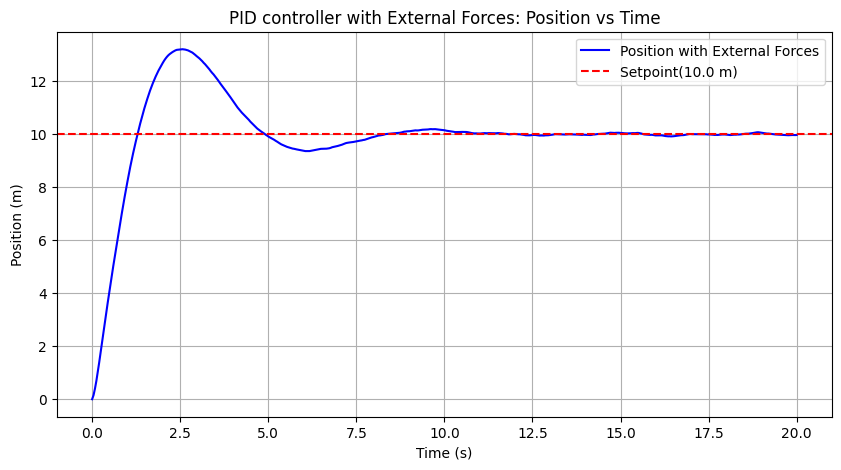

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position with External Forces', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label=f'Setpoint({setpoint} m)')
plt.title('PID controller with External Forces: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()

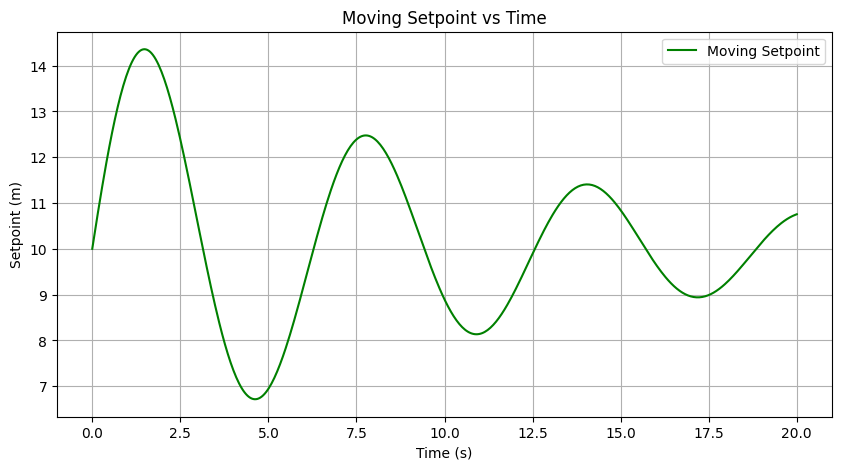

In [ ]:
## Moving setpoint
def moving_setpoint(t):
    """
    Example function of a moving setpoint that changes over time.

    Parameters:
    t (float): Current time.

    Returns:
    float: Setpoint value at time t.
    """
    return 10.0 + 5.0 * np.sin(1.0 * t) * np.exp(-0.09 * t)

#plot the moving setpoint
moving_setpoints = moving_setpoint(T)
plt.figure(figsize=(10, 5))
plt.plot(T, moving_setpoints, label='Moving Setpoint', color='green')
plt.title('Moving Setpoint vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Setpoint (m)')
plt.legend()
plt.grid()
plt.show()

In [15]:


K_p = 10.0  # proportional gain
K_d = 10.0   # derivative gain
K_i = 10.0   # integral gain

# Simulate the system with external forces
position = np.zeros(n)  # position
velocity = np.zeros(n)  # velocity
position[0] = start_position  # set initial position
velocity[0] = start_velocity  # set initial velocity


previous_error = calculate_error(moving_setpoints[0], position[0])  # initialize previous error
accumulated_error = previous_error

for i in range(1, n):
    # Calculate the error
    error = calculate_error(moving_setpoints[i], position[i-1])
    # Update accumulated error for integral term
    accumulated_error += error

    # Calculate the control input using the proportional term
    u = proportional_term(K_p, error)

    # Calculate the derivative term
    derivative = derivative_term(K_d, error, previous_error, dt)

    # Calculate the integral term
    integral = integration_term(K_i, accumulated_error, dt)

    u = u + derivative + integral  # add derivative and integral terms to control input

    # Calculate the acceleration
    a = acceleration(u, m, g)
    a += (wind_force(wind_amplitude=5) + drag_force(velocity[i-1], drag_coeff=1))  / m  # add external forces

    # Update velocity and position using Euler-Cromer method
    velocity[i] = velocity[i-1] + a * dt
    position[i] = position[i-1] + velocity[i] * dt

    previous_error = error  # update previous error for next iteration

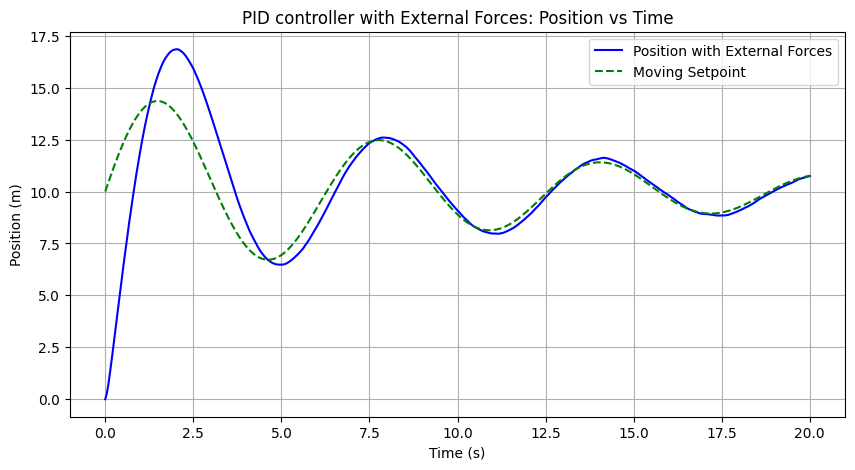

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(T, position, label='Position with External Forces', color='blue')
plt.plot(T, moving_setpoints, label='Moving Setpoint', color='green', linestyle='--')
plt.title('PID controller with External Forces: Position vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()